# Custom TF 2 model notebook
In the notebook you will learn how to build a custom model with Keras in TF2 and training it with a custom training loop.

Author: Daniel Wiczew

Contact: daniel.wiczew@gmail.com


In [1]:
# Install tensorflow 2.1 gpu if you're using google colab
!pip install tensorflow-gpu
# Remember to set to the GPU in the runtime type

     |████████████████████████████████| 421.8MB 35kB/s 
     |████████████████████████████████| 3.8MB 30.3MB/s 
     |████████████████████████████████| 450kB 57.4MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


In [2]:
# Check the graphic card
!nvidia-smi

Sun Feb 16 16:18:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Further, you have to import those libraries bellow
# If you don't have them in your system, just install them.
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
from glob import glob
%matplotlib inline
from matplotlib.pyplot import imshow, show, subplots, close
import seaborn as sns
sns.set()
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA

In [4]:
print('Gpu is available ?: ', tf.test.is_gpu_available())
print('Version of tensorflow: ', tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Gpu is available ?:  True
Version of tensorflow:  2.1.0


In [5]:
#If you want to use the code in the google colab - you can download the dataset from the 
!git clone https://github.com/DanielWicz/trashanomaly.git

Cloning into 'trashanomaly'...
remote: Enumerating objects: 996, done.
remote: Counting objects: 100% (996/996), done.
remote: Compressing objects: 100% (996/996), done.
remote: Total 996 (delta 1), reused 992 (delta 0), pack-reused 0
Receiving objects: 100% (996/996), 8.98 MiB | 20.47 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [0]:
# The functions normalizes in the scale 0-1.
# Since they are standarized before that, then dividing everything by 255 
# won't work here
def normalize(numpy_array):
  minimum = numpy_array.min()
  maximum = numpy_array.max()

  normalized = (numpy_array - minimum)/(maximum - minimum)

  return normalized

In [0]:
# Directories
## Training set
train_images_dir = 'trashanomaly/dataset/TRAIN'
## Testing set
test_images_dir = 'trashanomaly/dataset/TEST'
## Negative examples (non-plastic trash)
neg_images_dir = 'trashanomaly/dataset/NEG_TEST'
## Basic constants
EPOCHS = 1000
BATCH_SIZE = 256
INPUT_SHAPE = (127, 127)

In [0]:
# Loading images, rescaling and graying them
train_images = np.array([cv2.resize(cv2.imread(file, cv2.IMREAD_GRAYSCALE), INPUT_SHAPE) for file in glob(train_images_dir+'/*.jpg')])
test_images = np.array([cv2.resize(cv2.imread(file, cv2.IMREAD_GRAYSCALE), INPUT_SHAPE) for file in glob(test_images_dir+'/*.jpg')])
neg_images = np.array([cv2.resize(cv2.imread(file, cv2.IMREAD_GRAYSCALE), INPUT_SHAPE) for file in glob(neg_images_dir+'/*.jpg')])

# Create a new channel axis, as the grayed don't have the channel axis and tf.keras image generator 
# requires matrix's shape with the channel.
train_images = train_images[:,:,:,np.newaxis]
test_images = test_images[:,:,:,np.newaxis]
neg_images = neg_images[:,:,:,np.newaxis]

In [0]:
# Standarize Images with 0 mean and 1 variance
mean = np.mean(train_images ,axis=(0, 1, 2, 3))
std = np.std(train_images ,axis=(0, 1, 2, 3))
train_images = (train_images - mean)/(std + 1e-7)
test_images = (test_images - mean)/(std + 1e-7)
neg_images = (neg_images - mean)/(std + 1e-7)

# Normalize images
train_images = normalize(train_images)
test_images = normalize(test_images)
neg_images = normalize(neg_images)

In [0]:
# Training generator
# You can experiment with the augumentation parameters
# At the moment they are pretty heavy due to really small dataset
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=15, 
                                                            width_shift_range=0.10,
                                                            height_shift_range=0.10,
                                                            horizontal_flip=True,
                                                            vertical_flip=True,
                                                            zoom_range=0.10)

train_generator = train_gen.flow(   
    train_images,
    train_images,
    batch_size=BATCH_SIZE,
    shuffle=True
)


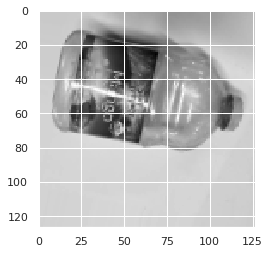

In [11]:
# Show an image from the train generator
imshow(np.squeeze(train_generator.next()[0][4]), cmap='gray')

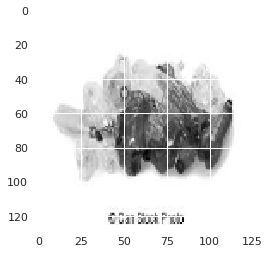

In [12]:
# And there is an example of test image - also bottlees
imshow(np.squeeze(test_images[0]), cmap='gray')

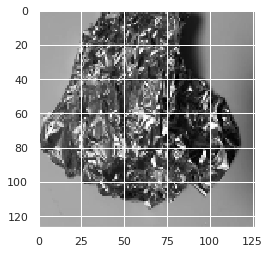

In [13]:
# Here is an example of negative test image - so not bottles
imshow(np.squeeze(neg_images[0]), cmap='gray')

## Autoencoder
The  autoencoder consists two parts - encoder and decoder. As it is obvious, from the programming point of view is not. You have to define two new classes that inherit from the `tf.keras.Model` class to get them work alone. As we are going to use only the encoder part to perform the anomaly detection, then seperating decoder from encoder is mandatory. 

### Model and how it should be built
The most important parts of the model class are two methods, `__init__` and `call`. All the layers, variables that are going to be further are defined in the `__init__` method. For example I have defined convolutional, dense and batch normalization layers in the init method. If you want to pass some parameters while creating the model (like filters' sizes), then you define them in the `__init__` method arguments. Remember that you are defining a class, then if you want to make available the defined objects/variables to other methods (e.g. `call` here) then you have to use `self`, e.g. `self.conv_layer_1 = tf.keras.layers.Conv2D(**parameters)`. 

Whereas in the `call` you define the sequence of operations that are going to be performed to obtain your desired output. You are using the objects which were defined in the `__init__` method and call them as a function. For example you take the `self.conv_layer_1` and pass a input to it `self.conv_layer_1(x)`, where `x` is a batch of images or something else. You also can perform here other operations, for example add a constant number like `x = x + 2` or split the output to two like `out_1 = self.some_object_1(x), out_2 = self.some_object_2(x)`, add a noise to the input with `x = x + tf.random.normal(shape=x.shape)` or anything else you would like to do. The only restrictions are that all the objects should be connected by input-output to calculate the shapes and differentiate them, and also they should be differentiable to allow optimization. I would like to remark also the `trainable` argument in the call, it should be passed to some layers like dropout or batch normalization, to ensure that they are in the training or testing mode. If it not done, then they are not working during training and in the case of batch normalization they are doing more harm than good. I usually set the default value to `trainable=False` to ensure that, when I'm using a trained model to test it, the batch normalization and dropout layers are turned off.

### Comment to the code
The code below may look pretty complicated, yet most of it is a repeated convolutional and dense layer. Pay attention to the comments inside the code, it should give you a clue how it works.


# Encoder part
Here is the encoder part, read comments to ensure that you understand how it is built.

In [0]:
# Here comes the main point of the notebook.
# Creating an model.
# Here is an model of encoder for the autoencoder used for anomaly detection.
# It can look 
class Encoder(tf.keras.Model):
  def __init__(self, fillters=[32, 64, 128, 196, 256, 1024], kernel_sizes=[3, 3, 3, 3, 3, 3], strides=[2, 2, 2, 2, 2, 2],
               input_shape=INPUT_SHAPE, num_of_layers=6):
    
    # Make sure to call the Layer's __init__ method
    # Without it, it will throw really strange errors  
    # that are hard to detect
    super(Encoder, self).__init__()
    # Since number of fillters is number of layers
    # then check whether it is equal
    # if it is different then raise the assertion exception
    # These parts are not essential but useful for the sake of
    # debuging
    assert(len(fillters) == num_of_layers)
    assert(len(kernel_sizes) == len(fillters))
    assert(len(strides) == len(fillters))
    # Just to not repeat the 'elu' everywhere
    activation = 'selu'
    # It can look pretty complicated, but it is just a repeated convolutional layer
    self.conv_layer_1 = tf.keras.layers.Conv2D(fillters[0], (kernel_sizes[0], kernel_sizes[0]), 
                                               strides=(strides[0], strides[0]),
                                               activation=activation)
    self.conv_layer_2 = tf.keras.layers.Conv2D(fillters[1], (kernel_sizes[1], kernel_sizes[1]), 
                                               strides=(strides[1], strides[1]),
                                               activation=activation)
    self.conv_layer_3 = tf.keras.layers.Conv2D(fillters[2], (kernel_sizes[2], kernel_sizes[2]), 
                                               strides=(strides[2], strides[2]),
                                               activation=activation)
    self.conv_layer_4 = tf.keras.layers.Conv2D(fillters[3], (kernel_sizes[3], kernel_sizes[3]), 
                                               strides=(strides[3], strides[3]),
                                               activation=activation)  
    self.conv_layer_5 = tf.keras.layers.Conv2D(fillters[4], (kernel_sizes[4], kernel_sizes[4]), 
                                               strides=(strides[4], strides[4]),
                                               activation=activation) 
    self.conv_layer_6 = tf.keras.layers.Conv2D(fillters[5], (kernel_sizes[5], kernel_sizes[5]), 
                                               strides=(strides[5], strides[5]),
                                               activation=activation) 
    # The same goes here, a repeated batch normalization layer
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()
    self.batch_norm_2 = tf.keras.layers.BatchNormalization()
    self.batch_norm_3 = tf.keras.layers.BatchNormalization()
    self.batch_norm_4 = tf.keras.layers.BatchNormalization()
    self.batch_norm_5 = tf.keras.layers.BatchNormalization()            
    self.batch_norm_6 = tf.keras.layers.BatchNormalization()                                         


    # Calculating the kernel size of the last layer, equating it to the shape of the layer's 2 output
    # It is needed for reshaping the output of the decoder model
    size = input_shape[0]
    for kernel_size, stride in zip(kernel_sizes, strides):
      size = tf.math.floor((size - kernel_size)/stride) + 1
    self.last_layer_kernel = int(size)
    self.flatten_layer = tf.keras.layers.Flatten()
    self.dense_layer_1 = tf.keras.layers.Dense(self.last_layer_kernel**2 * fillters[-1]/8 * 8, activation=activation)
    self.dense_layer_2 = tf.keras.layers.Dense(self.last_layer_kernel**2 * fillters[-1]/8 * 4, activation=activation)
    # This is definition of the output layer, that defines the latent variable in our encoder model
    self.dense_layer_out = tf.keras.layers.Dense(self.last_layer_kernel**2 * fillters[-1]/8 * 2)

  def last_layer_kernel_shape(self):
    """
    Returns the calculated kernel size
    for the last layer. This is necessary for the
    first layer in the decoder.
    """
    return self.last_layer_kernel

  # Remember to pass training=True in the training loop!
  # otherwise the batch_norm won't work
  def call(self, inputs, training=False):

    # Pass the input throught the layers
    x = self.conv_layer_1(inputs)
    x = self.batch_norm_1(x, training=training)
    x = self.conv_layer_2(x)
    x = self.batch_norm_2(x, training=training)
    x = self.conv_layer_3(x)
    x = self.batch_norm_3(x, training=training)
    x = self.conv_layer_4(x)
    x = self.batch_norm_4(x, training=training)
    x = self.conv_layer_5(x)
    x = self.batch_norm_5(x, training=training)
    x = self.conv_layer_6(x)
    x = self.batch_norm_6(x, training=training)
    x = self.flatten_layer(x)
    x = self.dense_layer_1(x)
    x = self.dense_layer_2(x)
    # This is our output layer, which is the latent variable
    x = self.dense_layer_out(x)    

    return x

# Here is the decoder part
Here is the decoder part, read comments to ensure that you understand how it is built.
This is almost a mirror image of the encoder, nevertheless, a symmetrical decoder in the autoencoder is not a must. There are many examples of asymmetrical autoencoders in scientific papers and they work well.

In [0]:

# Creating an encoder model
class Decoder(tf.keras.Model):
  def __init__(self, fillters=[1024, 256, 196, 128, 64, 32, 1], kernel_sizes=[3, 3, 3, 3, 3, 3, 1], strides=[2, 2, 2, 2, 2, 2, 1],
               input_kernel=None, num_of_layers=7):
    
    # Make sure to call the Layer's __init__ method
    super(Decoder, self).__init__()
    # Just to check up if everything is okay
    assert(len(fillters) == num_of_layers)
    assert(len(kernel_sizes) == len(fillters))
    assert(len(strides) == len(fillters))
    activation = 'selu'
    # Adjust the output_padding when you change the strides 
    # Or adjust the image site, which is usally easier
    self.conv_layer_1 = tf.keras.layers.Conv2DTranspose(fillters[0], (kernel_sizes[0], kernel_sizes[0]),
                                                        strides=(strides[0], strides[0]), 
                                                        activation=activation)
    self.conv_layer_2 = tf.keras.layers.Conv2DTranspose(fillters[1], (kernel_sizes[1], kernel_sizes[1]),
                                                        strides=(strides[1], strides[1]), 
                                                        activation=activation)
    self.conv_layer_3 = tf.keras.layers.Conv2DTranspose(fillters[2], (kernel_sizes[2], kernel_sizes[2]),
                                                        strides=(strides[2], strides[2]), 
                                                        activation=activation)
    self.conv_layer_4 = tf.keras.layers.Conv2DTranspose(fillters[3], (kernel_sizes[3], kernel_sizes[3]),
                                                        strides=(strides[3], strides[3]), 
                                                        activation=activation)
    self.conv_layer_5 = tf.keras.layers.Conv2DTranspose(fillters[4], (kernel_sizes[4], kernel_sizes[4]),
                                                        strides=(strides[4], strides[4]), 
                                                        activation=activation)
    self.conv_layer_6 = tf.keras.layers.Conv2DTranspose(fillters[5], (kernel_sizes[5], kernel_sizes[5]),
                                                        strides=(strides[5], strides[5]), 
                                                        activation=activation)
    # There is an additional layer that wraps up the autoencoder's signal and creates the output image
    self.conv_layer_7 = tf.keras.layers.Conv2DTranspose(fillters[6], (kernel_sizes[6], kernel_sizes[6]),
                                                        strides=(strides[6], strides[6]), 
                                                        activation='sigmoid')
    
    # An activation for the input
    self.activ = tf.keras.layers.Activation(activation)
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()
    self.batch_norm_2 = tf.keras.layers.BatchNormalization()
    self.batch_norm_3 = tf.keras.layers.BatchNormalization()
    self.batch_norm_4 = tf.keras.layers.BatchNormalization()
    self.batch_norm_5 = tf.keras.layers.BatchNormalization()
    self.batch_norm_6 = tf.keras.layers.BatchNormalization()
    self.batch_norm_7 = tf.keras.layers.BatchNormalization()
    # The "input_kernel" parameter is from the previous layer
    # The Dense's output is made so that, it fits the size of the reshaped image 
    # the reshaped image  - (input kernel, input kernel, fillters[0])
    self.dense_layer_1 = tf.keras.layers.Dense(input_kernel**2 * fillters[0]/8 * 8, activation=activation)
    self.reshape_layer = tf.keras.layers.Reshape((input_kernel, input_kernel, fillters[0]))
    
  # Remember to pass the training=True in the training loop!
  def call(self, inputs, training=False):

    # Pass the input throught the layers  
    x = self.activ(inputs) 
    x = self.dense_layer_1(x)
    x = self.reshape_layer(x)
    x = self.batch_norm_1(x, training=training)
    x = self.conv_layer_1(x)
    x = self.batch_norm_2(x, training=training)
    x = self.conv_layer_2(x)
    x = self.batch_norm_3(x, training=training)
    x = self.conv_layer_3(x)
    x = self.batch_norm_4(x, training=training)
    x = self.conv_layer_4(x)
    x = self.batch_norm_5(x, training=training)
    x = self.conv_layer_5(x)
    x = self.batch_norm_6(x, training=training)
    x = self.conv_layer_6(x)
    x = self.batch_norm_7(x, training=training)
    x = self.conv_layer_7(x)

    return x

# Creating model objects
Before we begin the training, we create the objects associated with the encoder and decoder. Those objects will be used for training, testing, and evaluation of the model. You just create an instance of the `Encoder` and `Decoder` classes and assign them to variables. If you want to pass some parameters, you just pass them to the created instance like in the case of `Decoder`. 

In [0]:
encoder = Encoder()
# The last_layer_kernel_shape passes the shape of the last convolutional layer.
# It is to ensure that the output will be the same for the first transpose convolutional
# layer in the Decoder.
last_layer_kernel_shape = encoder.last_layer_kernel_shape()
decoder = Decoder(input_kernel=last_layer_kernel_shape)


In [0]:
# Optimizer and loss function
learning_rate = 0.00015
ae_optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
# MSE works here best
loss_func = tf.keras.losses.MeanSquaredError()

# Custom training loop

## One training step - so where the backpropagation is performed
In the TF2 you're allowed to build loops where you can easily train any model. The loop consists of a part of code where backpropagation is performed and I call it a `train_step` and define it as a function. The rest of the training loop is described later.

The backpropagation part or `train_step` consists of two parts, the part where the loss is evaluated and the part where the gradient is calculated and applied to the weights.
The first part is always defined within the `with tf.GradientTape() as` statement. You can call the tape under any name, not only `ae_tape`, so the layer does not matter. Then under the statement, you define the operations where backpropagation is performed, so the loss functions and encoder and decoder. Then you assign the trained variables to a variable (as they are in a form of a list, you can join the list with the `+` sign). There is a small remark I would say, that the variables don't need to be always passed to the gradient evaluation, for example in some cases (generator in GAN networks) only part of the weights are updated, e.g. generator, where decoder would be left not updated. Then you would assign to the trainable variables only `trainable_vars = generator.trainable_variables`. 

The second part is calculating the gradient and applying it. With the tape variable ae_tape you call `gradient` and pass the loss and variables and it outputs gradients. Then you apply the gradients with optimizer of your choice as a gradient - variable tuple, using Python's zip method. Furthermore, you can also modify the gradient, e.g. apply a gradient clipping to the `ae_grads` variable or remove all the NaNs (which is not recommended) from the gradient. 

## Why training step as a function

It is not only more convenient to make the training step a function, but also you can use the @tf.function decorator. It ensures that the graph is built in a non-eager model, which makes the computation far faster (sometimes tenfold). Nevertheless, it is almost impossible to debug it if the decorator is applied, thus while debugging, just comment out the decorator. 
Furthermore, you can pass any number of parameters you like, and process them in the function to get the desired result. Thus not only input but target variables are also allowed.


In [0]:
# One step of training
# The tf.function decorator indicates the graph
# While you're debuging, make sure that 
# the @tf.function is commented out
# This will make debugging far more easier
@tf.function
def train_step(input, target):
  with tf.GradientTape() as ae_tape:
    # Pass the input to the encoder
    # Ensure for the training=True
    # Otherwise the batchnorm won't work
    encode_inp = encoder(input, training=True)
    # Pass the encoder's output to the decoder
    decode_inp = decoder(encode_inp, training=True)
    # The prediction variable is just for clarity
    prediction = decode_inp
    # Calculate loss
    loss = loss_func(input, prediction)
    # Get the encoder and decoder variables
    trainable_vars = encoder.trainable_variables \
                     + decoder.trainable_variables
  # Calculate gradient          
  ae_grads = ae_tape.gradient(loss, trainable_vars)
  # And then apply the gradient to change the weights
  ae_optimizer.apply_gradients(zip(ae_grads, trainable_vars))

  # Loss is returned to monitor it while training
  return loss

## Training loop 
After defining one training step, you define the whole training process.
Usually, you create two loops, where one is responsible for dividing the whole process into epochs, and the other into batches. 
In the batch loop, you call the training step and pass the input and output (since here we have an autoencoder, the input is the same as output, so you could just pass twice the input). 

In [19]:
# Number of iters is here to iterate through all the 
# exaples in the dataset. If you won't call the generator
# previously it can throw an exception.
train_generator.next()
num_of_iters = int((max(train_generator.index_array) + 1)/BATCH_SIZE)
loss_array = []
loss_array_disc = []
print("Starting training ...")
for epoch in range(EPOCHS):
  # Just total loss
  loss_tot = 0
  # Iterate through all the examples
  for iteration, (input, target) in enumerate(train_generator):
    # Break if the number of computed batches exceeds the
    # total number of the examples
    if iteration >= num_of_iters:
      break
    loss = train_step(input, target)
    loss_tot += loss
  loss_array.append((epoch, float(loss_tot)))
  # Print the total loss every epoch
  print('\nLoss for epoch {0} is {1}'.format(epoch, loss_tot))

Starting training ...

Loss for epoch 0 is 0.4684070944786072

Loss for epoch 1 is 0.33459770679473877

Loss for epoch 2 is 0.27256762981414795

Loss for epoch 3 is 0.24747775495052338

Loss for epoch 4 is 0.22756926715373993

Loss for epoch 5 is 0.20809859037399292

Loss for epoch 6 is 0.20793160796165466

Loss for epoch 7 is 0.19650115072727203

Loss for epoch 8 is 0.19327792525291443

Loss for epoch 9 is 0.174993634223938

Loss for epoch 10 is 0.17731758952140808

Loss for epoch 11 is 0.1878616362810135

Loss for epoch 12 is 0.17110641300678253

Loss for epoch 13 is 0.17148979008197784

Loss for epoch 14 is 0.16468197107315063

Loss for epoch 15 is 0.15747711062431335

Loss for epoch 16 is 0.15468409657478333

Loss for epoch 17 is 0.1493016630411148

Loss for epoch 18 is 0.15089139342308044

Loss for epoch 19 is 0.14462503790855408

Loss for epoch 20 is 0.14340178668498993

Loss for epoch 21 is 0.1427096128463745

Loss for epoch 22 is 0.12217368930578232

Loss for epoch 23 is 0.1304

# After the training

Here evaluation and testing of the model is performed

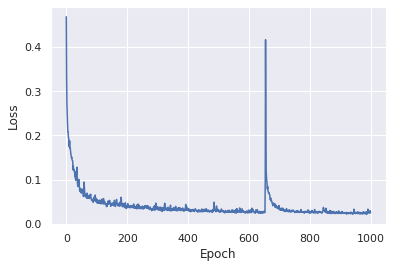

In [20]:
# Ploting the loss versus epochs
df = pd.DataFrame(np.array(loss_array), columns=['Epoch' ,'Loss'])
sns.lineplot(data=df, x='Epoch', y='Loss')

Here you can visualize the reconstructed image on the test images, it is usually helpful to examine them if they are reconstructed properly. Of course, they won't be in 100% the same, but the major features (like the shape of a bottle) should be reconstructed.

In [21]:
# Take one test example
y = test_images
# Pass to the trained encoder
e = encoder(y)
# pass the encoded value back to the decoder
d = decoder(e)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



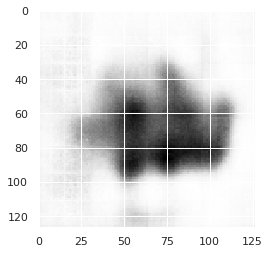

In [43]:
# Show decoded image
# Just change the index from 0 to n to see other images
imshow(np.squeeze(d[0]), cmap='gray')

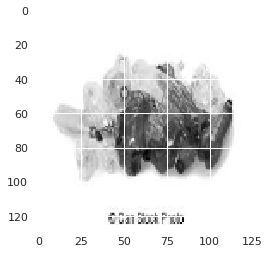

In [44]:
# Show oryginal image
imshow(np.squeeze(y[0]), cmap='gray')

# Showing the reduced representation of the latent space
Using PCA you can visualize how the latent space looks like. Similar examples should cluster with other similar examples due to the clustering properties of the autoencoder. The clustering won't be the highest quality, yet there should be any.

The plot represents negative (non-bottles) and positive (bottles) test examples as blue and orange. You can see that orange examples cluster together with the blue examples. Sometimes there are outliers and it is better to change the axis scale to see the clusters.

In [0]:
encoded_trian = np.squeeze(encoder(train_images).numpy())
encoded_test = np.squeeze(encoder(test_images))
encoded_neg = np.squeeze(encoder(neg_images))
new_encoded = np.stack([encoded_test, encoded_neg])
pca = PCA(n_components=2)
pca_results = pca.fit_transform(encoded_trian)
pca_neg = pca.transform(encoded_neg)
pca_pos = pca.transform(encoded_test)

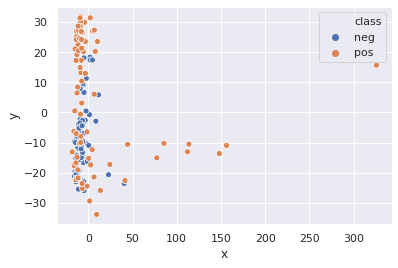

In [25]:
pca_pos = [('pos', x[0], x[1])for x in pca_pos]
pca_neg = [('neg', x[0], x[1])for x in pca_neg]
df_pca = pd.DataFrame(pca_neg+pca_pos, columns=['class', 'x', 'y'])
sns.scatterplot(data=df_pca, x='x', y='y', hue='class')

# Creating a GMM model for the outlier detection 
To detect the outliers we will use the Gaussian Mixture Model, which allows for clustering multi-dimensional data and classifying them with a probabilistic model using Gaussian distributions (the number of them is specified with n_components). 
To read more see this page: https://scikit-learn.org/stable/modules/mixture.html

The most important parameters here are the number of the components that, describe the clustered data and n_init which a number of initializations (usually the more, the better but requires more time). 

In [0]:
# Create a GMM model for the N gaussian components
# You can play with the number of components to get the right accuracy
# You may lower the n_init number to lower the time needed for training
# nevertheless, the overall performance can be lower.
gmm = GaussianMixture(n_components=6, tol=10e-10, max_iter=600, n_init=200)

In [0]:
# Pass the images from the dataset with the bottles
# And get the encoder's latent variable
encoded_trian = np.squeeze(encoder(train_images))
encoded_trian_bott = np.squeeze(encoder(train_images))
# Fit the gmm model with the latent variable generated using the training set
gmm.fit(encoded_trian)
# Calculate the 
Train_score = gmm.score_samples(encoded_trian_bott)
# With the standard deviation you can control the sensitivity and specificity
# for the GMM model.
threshold = Train_score.mean() - 3 * Train_score.std()

In [0]:
test_pos = np.squeeze(encoder(test_images))
test_neg = np.squeeze(encoder(neg_images))
score_pos = gmm.score_samples(test_pos)
score_neg = gmm.score_samples(test_neg)

In [35]:
pos_acc = np.sum(score_pos < threshold)/score_pos.shape[0]
neg_acc = np.sum(score_neg > threshold)/score_neg.shape[0]
all_acc = (np.sum(score_neg > threshold)+np.sum(score_pos < threshold))/(score_neg.shape[0]+score_pos.shape[0])
print('Sensitivity (detecting bottles): {}'.format(pos_acc))
print('Specificity (detecting non-bottle things): {}'.format(neg_acc))
print('Accuracy: {}'.format(all_acc))


Sensitivity (detecting bottles): 0.7
Specificity (detecting non-bottle things): 0.825
Accuracy: 0.7625


# Saving the model and using it outside the training protocol
Using a custom-built model is a little tricky in comparison to the Keras models. Did you notice that the input shape was not specified? So then how the shapes of weight matrices are calculated then? It is performed while you first call the model object with an input, thus to load a model first you have to define it and pass input with the same shape as previously (for example a zero-filled tensor). Then you're able to load the model.

To define the model, you have to save somewhere the configuration. Since the `to_json` method is not implemented for the non-sequential models, then you have to save it by yourself. I usually do it by creating a dictionary where all the model's parameters are stored.

In [0]:
# Saving the configuration
import json
## Encoder
encoder_dict = {'fillters': [32, 64, 128, 196, 256, 1024],
                'kernel_sizes': [3, 3, 3, 3, 3, 3],
                'strides': [2, 2, 2, 2, 2, 2],
                'num_of_layers': 6}
with open('encoder_config.json', 'w') as fp:
    json.dump(encoder_dict, fp)

## Decoder
decoder_dict = {'fillters': [1024, 256, 196, 128, 64, 32, 1], 
                'kernel_sizes': [3, 3, 3, 3, 3, 3, 1],
                'strides': [2, 2, 2, 2, 2, 2, 1],
                'num_of_layers': 7}
with open('decoder_config.json', 'w') as fp:
    json.dump(decoder_dict, fp)

# Saving weights
After the configuration is saved, you can save also the weights.

In [0]:
# Saving the model
## Encoder
encoder.save_weights(filepath='encoder_model.tf')
## Decoder
decoder.save_weights(filepath='decoder_model.tf')

# Loading the model
As previously mentioned, it is a bit complicated, although we are ready for it, so it should go smoothly.

In [36]:
# Loading the model
## Load the config
with open('encoder_config.json', 'r') as fp:
    encoder_config = json.load(fp)
with open('decoder_config.json', 'r') as fp:
    decoder_config = json.load(fp)

## Initialize encoder and decoder model objects
## The ** means unpacking the dictionary
encoder_new = Encoder(**encoder_config, input_shape=(127, 127))
### Pass a zeros vector to initialize the weight's shapes
latent = encoder(tf.zeros((1, 127, 127, 1)))
last_layer_shape = encoder_new.last_layer_kernel_shape()
decoder_new = Decoder(**decoder_config, input_kernel=last_layer_shape)
### Pass a zeros vector to initialize the weight's shapes
decoded = decoder_new(latent)
## Load the weights
encoder_new.load_weights(filepath='encoder_model.tf')
decoder_new.load_weights(filepath='decoder_model.tf')

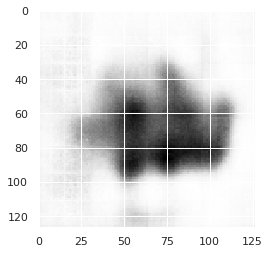

In [45]:
# Test the loaded models
latent = encoder_new(test_images[np.newaxis, 0, :, :])
decoded = decoder_new(latent)
imshow(np.squeeze(decoded[0]), cmap='gray')